In [ ]:
!apt-get -qq install -y ffmpeg

In [ ]:
!pip install openl3 faiss-cpu torchopenl3 soundfile librosa tqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Define the base project path
project_path = '/content/drive/MyDrive/ESE 5460/Project'


os.makedirs(project_path, exist_ok=True)

os.chdir(project_path)

print(f"Current working directory set to: {os.getcwd()}")

Mounted at /content/drive
Current working directory set to: /content/drive/MyDrive/ESE 5460/Project


In [ ]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchaudio
import torchopenl3
import faiss

# Paths
GTZAN_ROOT = "data/gtzan_raw"      # REAL songs
AI_DIR = "data/sonics_raw"     # FAKE songs / query points

assert os.path.isdir(GTZAN_ROOT), f"Missing: {GTZAN_ROOT}"
assert os.path.isdir(AI_DIR), f"Missing: {AI_DIR}"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
TARGET_SR = 16000  # downsample everything to 16k
DURATION  = 30.0   # seconds
SAMPLES   = int(TARGET_SR * DURATION)

# TorchOpenL3 config
CONTENT_TYPE = "music"
INPUT_REPR   = "mel128"
EMBED_SIZE   = 512
HOP_SIZE     = 0.1 # number of seconds to jump
CENTER       = True
BATCH_SIZE   = 32

# Pooling -> one vector per track
POOLING      = "mean"   # "mean" or "max"
L2_NORMALIZE = True


In [ ]:
def list_audio_files(root: str, exts=(".wav", ".mp3", ".flac", ".m4a", ".ogg", ".aiff", ".aac")):
    files = glob.glob(os.path.join(root, "**", "*"), recursive=True)
    files = [f for f in files if os.path.isfile(f) and os.path.splitext(f)[1].lower() in exts]
    files.sort()
    return files

In [ ]:
def infer_label_from_path(path: str) -> str:
    # Works with GTZAN layout: .../genres_original/<genre>/<file>.wav
    parts = os.path.normpath(path).split(os.sep)
    if "genres_original" in parts:
        i = parts.index("genres_original")
        if i + 1 < len(parts):
            return parts[i + 1]
    return os.path.basename(os.path.dirname(path))

def load_audio_fixed(path: str, target_sr: int, n_samples: int):
    """
    Load -> mono -> resample -> trim/pad to fixed length
    Returns: (audio_np_float32, sr)
    """
    wav, sr = torchaudio.load(path)          # (C, T)
    wav = wav.mean(dim=0, keepdim=True)      # mono (1, T)

    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, sr, target_sr)

    wav = wav.squeeze(0)  # (T,)

    if wav.numel() > n_samples:
        wav = wav[:n_samples]
    elif wav.numel() < n_samples:
        wav = torch.nn.functional.pad(wav, (0, n_samples - wav.numel()))
    return wav.cpu().numpy().astype(np.float32), target_sr

def pool_embedding(emb_TxD: np.ndarray) -> np.ndarray:
    """
    Convert frame-level OpenL3 embeddings (T, D) -> song-level vector (D,)
    """
    if POOLING == "mean":
        v = emb_TxD.mean(axis=0)
    elif POOLING == "max":
        v = emb_TxD.max(axis=0)
    else:
        raise ValueError("POOLING must be 'mean' or 'max'")

    if L2_NORMALIZE:
        v = v / (np.linalg.norm(v) + 1e-12)

    return v.astype(np.float32)


In [ ]:
tmodel = torchopenl3.models.load_audio_embedding_model(
    input_repr=INPUT_REPR,
    content_type=CONTENT_TYPE,
    embedding_size=EMBED_SIZE
).to(device).eval()

print("TorchOpenL3 model loaded.")


Downloading: "https://github.com/torchopenl3/torchopenl3-models/raw/master/torchopenl3_mel128_music_512.pth.tar" to /root/.cache/torch/hub/checkpoints/torchopenl3_mel128_music_512.pth.tar
100%|██████████| 34.4M/34.4M [00:00<00:00, 293MB/s]


TorchOpenL3 model loaded.


In [ ]:
# HAVEN'T WIRED THIS IN YET BUT I CACHED EMBEDDINGS AT END
def load_gtzan_embeddings(
    cache_dir: str = "embeddings_cache",
    pooled: bool = True,
    build_faiss: bool = True,
):
    meta_path = os.path.join(cache_dir, "gtzan_real_meta.csv")
    assert os.path.exists(meta_path), f"Missing {meta_path}"

    meta = pd.read_csv(meta_path)

    if pooled:
        X_path = os.path.join(cache_dir, "gtzan_real_X_pooled.npy")
        assert os.path.exists(X_path), f"Missing {X_path}"
        X = np.load(X_path)

        if X.ndim != 2:
            raise ValueError(f"Pooled embeddings must be (N, D), got {X.shape}")

        # Ensure float32 + contiguous for FAISS
        X = np.ascontiguousarray(X, dtype=np.float32)

    else:
        X_path = os.path.join(cache_dir, "gtzan_real_X.npy")
        assert os.path.exists(X_path), f"Missing {X_path}"
        X = np.load(X_path)

        if X.ndim != 3:
            raise ValueError(f"Frame-level embeddings must be (N, T, D), got {X.shape}")

    index = None
    if build_faiss:
        if not pooled:
            raise ValueError("FAISS index requires pooled=True embeddings")

        d = X.shape[1]
        index = faiss.IndexFlatIP(d)
        index.add(X)

    print("Loaded embeddings:")
    print("  X shape:", X.shape)
    print("  meta rows:", len(meta))
    if index is not None:
        print("  FAISS index size:", index.ntotal)

    return X, meta, index


In [ ]:
# Embed audio file given by path into an OpenL3 embedding
@torch.no_grad()
def embed_path(path: str) -> np.ndarray:
    audio, sr = load_audio_fixed(path, TARGET_SR, SAMPLES)

    emb, ts = torchopenl3.get_audio_embedding(
        audio=audio,
        sr=sr,
        model=tmodel,
        hop_size=HOP_SIZE,
        center=CENTER,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    if isinstance(emb, torch.Tensor):
        emb = emb.detach().cpu().numpy()
    else:
        emb = np.asarray(emb)

    if emb.ndim == 3 and emb.shape[0] == 1:
        emb = emb[0]  # (T, D)

    if emb.ndim != 2:
        raise ValueError(f"Expected (T, D) or (1, T, D), got {emb.shape}")

    v = emb.mean(axis=0)  # (D,)
    v /= np.linalg.norm(v) + 1e-12
    return v.astype(np.float32)


In [ ]:
# Embed every file in folder [.wav files in this case]
def embed_folder_to_matrix(root: str, add_label: bool = False, desc: str = "Embedding"):
    files = list_audio_files(root)
    if not files:
        raise FileNotFoundError(f"No .wav files found under {root}")

    rows = []
    vecs = []
    skipped = 0

    for p in tqdm(files, desc=desc):
        try:
            v = embed_path(p)
        except Exception as e:
            skipped += 1
            print(f"[SKIP] {p} ({type(e).__name__}: {e})")
            continue

        row = {"path": p}
        if add_label:
            row["label"] = infer_label_from_path(p)
        rows.append(row)
        vecs.append(v)

    if not vecs:
        raise RuntimeError(f"No embeddings produced from {root} (all files failed).")

    dims = sorted(set(v.shape[0] for v in vecs))
    print("Unique dims:", dims, "| embedded:", len(vecs), "| skipped:", skipped)
    if len(dims) != 1:
        raise ValueError(f"Inconsistent embedding dimensions: {dims}")

    X = np.stack(vecs, axis=0).astype(np.float32)
    meta = pd.DataFrame(rows)
    return X, meta




In [ ]:
# # Real songs: GTZAN
# X_real, meta_real = embed_folder_to_matrix(
#     GTZAN_ROOT,
#     add_label=True,
#     desc="Embedding GTZAN (REAL)"
# )

# print("X_real:", X_real.shape)
# display(meta_real.head())

#-------------------------LOAD EMBEDDINGS-------------------------

In [ ]:
# HAVEN'T WIRED THIS IN YET BUT I CACHED EMBEDDINGS AT END
def load_gtzan_embeddings(
    cache_dir: str = "embeddings_cache",
    pooled: bool = True,
    build_faiss: bool = True,
):
    meta_path = os.path.join(cache_dir, "gtzan_real_meta.csv")
    assert os.path.exists(meta_path), f"Missing {meta_path}"

    meta = pd.read_csv(meta_path)

    if pooled:
        X_path = os.path.join(cache_dir, "gtzan_real_X_pooled.npy")
        assert os.path.exists(X_path), f"Missing {X_path}"
        X = np.load(X_path)

        if X.ndim != 2:
            raise ValueError(f"Pooled embeddings must be (N, D), got {X.shape}")

        # Ensure float32 + contiguous for FAISS
        X = np.ascontiguousarray(X, dtype=np.float32)

    else:
        X_path = os.path.join(cache_dir, "gtzan_real_X.npy")
        assert os.path.exists(X_path), f"Missing {X_path}"
        X = np.load(X_path)

        if X.ndim != 3:
            raise ValueError(f"Frame-level embeddings must be (N, T, D), got {X.shape}")

    print("Loaded embeddings:")
    print("  X shape:", X.shape)
    print("  meta rows:", len(meta))

    return X, meta


In [ ]:
X_real_song, meta_real = load_gtzan_embeddings(pooled=True)

Loaded embeddings:
  X shape: (999, 512)
  meta rows: 999


## KNN with FAISS

In [ ]:
print(X_real_song.shape)  # (999, 512)

(999, 512)


In [ ]:
# # Pool time dimension
# X_real_song = X_real.mean(axis=1).astype(np.float32)

# # L2 normalize (important for cosine similarity)
# X_real_song /= np.linalg.norm(X_real_song, axis=1, keepdims=True) + 1e-12

# print(X_real_song.shape)  # (999, 512)

In [ ]:
d = X_real_song.shape[1]

# Since we L2-normalized, inner product == cosine similarity
index = faiss.IndexFlatIP(d)
index.add(X_real_song)

print("FAISS index built. Total vectors:", index.ntotal)


FAISS index built. Total vectors: 999


In [ ]:
def knn_query_vector(q_vec: np.ndarray, k: int = 10):
    q = q_vec.astype(np.float32)[None, :]  # (1, D)
    scores, idxs = index.search(q, k)
    out = meta_real.iloc[idxs[0]].copy()
    out["score"] = scores[0]
    return out

def knn_query_path(query_path: str, k: int = 10):
    q_vec = embed_path(query_path)
    return knn_query_vector(q_vec, k=k)

In [ ]:
ai_files = list_audio_files(AI_DIR)

metadata_path = os.path.join(project_path, "data/sonics_raw/metadata/fake_songs.csv")

# Read the metadata CSV
try:
    ai_metadata_df = pd.read_csv(metadata_path)
except FileNotFoundError:
    print(f"Error: Metadata file not found at {metadata_path}")
    ai_metadata_df = pd.DataFrame()

genre_mapping = {}
if not ai_metadata_df.empty:
    for _, row in ai_metadata_df.iterrows():
        filename_base = row['filename']
        genre_mapping[filename_base] = row['genre']

# Map ai_files path with its corresponding "genre" field
ai_files_with_genres = []
for full_path in ai_files:
    filename_with_ext = os.path.basename(full_path)
    filename_base, _ = os.path.splitext(filename_with_ext)
    genre = genre_mapping.get(filename_base, "unknown")
    ai_files_with_genres.append((full_path, genre))

print("SONICS wav count:", len(ai_files))
print("Example SONICS file:", ai_files[1] if len(ai_files) > 1 else "None")

/tmp/ipython-input-19-696480165.py:9: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ai_metadata_df = pd.read_csv(metadata_path)


SONICS wav count: 285
Example SONICS file: data/sonics_raw/fake_54177_udio_1.mp3


In [ ]:
if not ai_metadata_df.empty:
    print("\nAll unique genres from metadata_path:")
    print(ai_metadata_df['genre'].unique())
else:
    print("Metadata DataFrame is empty, cannot extract genres.")



All unique genres from metadata_path:
['lounge' 'salsa' 'grunge' 'christian rock' 'smooth jazz' 'hard rock'
 'disco' 'dance' 'heavy metal' 'new age' 'r&b' 'doom metal' 'gospel'
 'fusion' 'world music' 'celtic' 'indie rock' 'punk' 'progressive rock'
 'folk' 'pop rock' 'pop' 'metal' 'blues' 'classical' 'grime' 'jazz'
 'baroque' 'hip hop' 'electronic' 'dancehall' 'country' 'j-pop'
 'alternative' 'k-pop' 'reggae' 'metalcore' 'bollywood' 'crunk' 'soul'
 'progressive metal' 'orchestral' 'gothic' 'opera' 'rap' 'sufi' 'funk'
 'lo-fi' 'c-pop' nan]


In [ ]:
import numpy as np
import os
from tqdm import tqdm

# Caching mechanism for map_ai_genre_to_closest_real
_ai_genre_to_real_map_cache = {}

def map_ai_genre_to_closest_real(
    ai_genre_to_map: str,
    target_real_genres: list,
    gtzan_genre_centroids: dict,
    ai_files_with_genres: list
) -> str:
    # IMMEDIATE CHECK: If the AI genre is already in the target list, return it.
    if ai_genre_to_map in target_real_genres:
        print(f"AI genre '{ai_genre_to_map}' is already a target real genre. No mapping needed.")
        return ai_genre_to_map

    # Use caching to prevent re-computation
    cache_key = (ai_genre_to_map, tuple(sorted(target_real_genres)))
    if cache_key in _ai_genre_to_real_map_cache:
        print(f"Using cached result for AI genre '{ai_genre_to_map}'")
        return _ai_genre_to_real_map_cache[cache_key]

    print(f"Mapping AI genre '{ai_genre_to_map}' to closest real genre from {target_real_genres}...")

    # Calculate centroid
    ai_songs_for_this_genre = [path for path, genre in ai_files_with_genres if genre == ai_genre_to_map]

    if not ai_songs_for_this_genre:
        result = f"No AI songs found for genre '{ai_genre_to_map}' to form a centroid."
        _ai_genre_to_real_map_cache[cache_key] = result
        return result

    ai_song_embeddings = []
    print(f"Embedding {len(ai_songs_for_this_genre)} songs for AI genre '{ai_genre_to_map}'...")

    for ai_song_path in tqdm(ai_songs_for_this_genre, desc=f"Embedding AI songs for '{ai_genre_to_map}'"):
        try:
            emb = embed_path(ai_song_path)
            ai_song_embeddings.append(emb)
        except Exception as e:
            print(f"[ERROR] Skipping AI song {os.path.basename(ai_song_path)} for centroid calculation: {e}")
            continue

    if not ai_song_embeddings:
        result = f"Failed to embed any songs for AI genre '{ai_genre_to_map}'. Cannot form centroid."
        _ai_genre_to_real_map_cache[cache_key] = result
        return result

    ai_genre_centroid = np.mean(ai_song_embeddings, axis=0)
    ai_genre_centroid = ai_genre_centroid / (np.linalg.norm(ai_genre_centroid) + 1e-12) # L2 normalize

    filtered_gtzan_centroids = {}
    for genre in target_real_genres:
        if genre in gtzan_genre_centroids:
            filtered_gtzan_centroids[genre] = gtzan_genre_centroids[genre]
        else:
            print(f"Warning: Real genre '{genre}' not found in GTZAN centroids. Skipping.")

    if not filtered_gtzan_centroids:
        result = f"None of the target real genres {target_real_genres} found in GTZAN centroids."
        _ai_genre_to_real_map_cache[cache_key] = result
        return result

    max_similarity = -1
    closest_real_genre = "No match found"

    for real_genre, real_centroid in filtered_gtzan_centroids.items():
        similarity = np.dot(ai_genre_centroid, real_centroid)
        if similarity > max_similarity:
            max_similarity = similarity
            closest_real_genre = real_genre

    result = closest_real_genre
    _ai_genre_to_real_map_cache[cache_key] = result
    print(f"AI genre '{ai_genre_to_map}' is most similar to real genre: '{closest_real_genre}' (Similarity: {max_similarity:.4f})")
    return result

print("Pre-computing GTZAN genre centroids...")
gtzan_genre_centroids = {}

if 'meta_real' in locals() and 'X_real_song' in locals():
    for genre_label in meta_real['label'].unique():
        genre_indices = meta_real[meta_real['label'] == genre_label].index
        valid_indices = [i for i in genre_indices if i < len(X_real_song)]

        if valid_indices:
            genre_embeddings = X_real_song[valid_indices]
            centroid = np.mean(genre_embeddings, axis=0)
            centroid = centroid / (np.linalg.norm(centroid) + 1e-12) # L2 normalize
            gtzan_genre_centroids[genre_label] = centroid
        else:
            print(f"Warning: No valid embeddings found for GTZAN genre '{genre_label}'.")
    print("GTZAN genre centroids pre-computed.")
else:
    print("Skipped pre-computation: 'meta_real' or 'X_real_song' not defined in this scope.")

Pre-computing GTZAN genre centroids...
GTZAN genre centroids pre-computed.


In [ ]:
target_real_genres = ["metal", "disco", "classical", "blues", "hiphop", "jazz", "country", "rock", "pop", "reggae"]

# Task
Identify the first AI song and its genre from the `ai_files_with_genres` list. Then, map this AI genre to its closest real GTZAN genre using the `map_ai_genre_to_closest_real` function with the pre-computed `gtzan_genre_centroids`. After obtaining the mapped real genre, perform a k-nearest neighbors query (`k=100`) for the first AI song using `knn_query_path`. Finally, filter these 100 results to include only those songs belonging to the mapped real genre, and display the top 10 such songs sorted by cosine similarity in descending order.

In [ ]:
if ai_files_with_genres:
    first_ai_file_path, first_ai_genre = ai_files_with_genres[0]
    print(f"First AI file path: {first_ai_file_path}")
    print(f"First AI genre: {first_ai_genre}")
else:
    print("The ai_files_with_genres list is empty.")

mapped_real_genre = map_ai_genre_to_closest_real(
    ai_genre_to_map=first_ai_genre,
    target_real_genres=target_real_genres,
    gtzan_genre_centroids=gtzan_genre_centroids,
    ai_files_with_genres=ai_files_with_genres
)

print(f"The AI genre '{first_ai_genre}' is mapped to the real genre: '{mapped_real_genre}'.")

First AI file path: data/sonics_raw/fake_54177_udio_0.mp3
First AI genre: salsa
Mapping AI genre 'salsa' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 12 songs for AI genre 'salsa'...


Embedding AI songs for 'salsa': 100%|██████████| 12/12 [00:29<00:00,  2.50s/it]

AI genre 'salsa' is most similar to real genre: 'reggae' (Similarity: 0.9910)
The AI genre 'salsa' is mapped to the real genre: 'reggae'.


In [ ]:
print(f"Performing KNN query for AI song: {first_ai_file_path} (AI genre: {first_ai_genre}) and filtering for mapped real genre: {mapped_real_genre}")

k = 100
knn_results = knn_query_path(first_ai_file_path, k=k)

filtered_knn_results = knn_results[knn_results['label'] == mapped_real_genre]

top_10_filtered_results = filtered_knn_results.sort_values(by='score', ascending=False).head(10)

print(f"\nTop 10 KNN results for AI song '{os.path.basename(first_ai_file_path)}' matching real genre '{mapped_real_genre}':")
display(top_10_filtered_results)

Performing KNN query for AI song: data/sonics_raw/fake_54177_udio_0.mp3 (AI genre: salsa) and filtering for mapped real genre: reggae

Top 10 KNN results for AI song 'fake_54177_udio_0.mp3' matching real genre 'reggae':


,path,label,score
858,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988719
883,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988675
806,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988383
863,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988383
893,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988311
846,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988166
855,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987963
869,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987688
804,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987597
824,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987525


In [ ]:
# # Run one query (top-10 similar REAL GTZAN songs)
# if ai_files:
#     print("\nKNN query for the first AI file:")
#     display(knn_query_path(ai_files[0], k=10))


In [ ]:
if ai_files_with_genres:
    first_ai_file_path, first_ai_genre = ai_files_with_genres[0]
    print(f"First AI file path: {first_ai_file_path}")
    print(f"First AI genre: {first_ai_genre}")
else:
    print("The ai_files_with_genres list is empty.")

mapped_real_genre = map_ai_genre_to_closest_real(
    ai_genre_to_map=first_ai_genre,
    target_real_genres=target_real_genres,
    gtzan_genre_centroids=gtzan_genre_centroids,
    ai_files_with_genres=ai_files_with_genres
)

print(f"The AI genre '{first_ai_genre}' is mapped to the real genre: '{mapped_real_genre}'.")

print(f"Performing KNN query for AI song: {first_ai_file_path} (AI genre: {first_ai_genre}) and filtering for mapped real genre: {mapped_real_genre}")

k = 100
knn_results = knn_query_path(first_ai_file_path, k=k)

filtered_knn_results = knn_results[knn_results['label'] == mapped_real_genre]

top_10_filtered_results = filtered_knn_results.sort_values(by='score', ascending=False).head(10)

print(f"\nTop 10 KNN results for AI song '{os.path.basename(first_ai_file_path)}' matching real genre '{mapped_real_genre}':")
display(top_10_filtered_results)

First AI file path: data/sonics_raw/fake_54177_udio_0.mp3
First AI genre: salsa
Using cached result for AI genre 'salsa'
The AI genre 'salsa' is mapped to the real genre: 'reggae'.
Performing KNN query for AI song: data/sonics_raw/fake_54177_udio_0.mp3 (AI genre: salsa) and filtering for mapped real genre: reggae

Top 10 KNN results for AI song 'fake_54177_udio_0.mp3' matching real genre 'reggae':


,path,label,score
858,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988719
883,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988675
806,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988383
863,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988383
893,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988311
846,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.988166
855,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987963
869,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987688
804,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987597
824,data/gtzan_raw/genres_original/reggae/reggae.0...,reggae,0.987525


In [ ]:
os.makedirs("embeddings_cache", exist_ok=True)

# np.save("embeddings_cache/gtzan_real_X.npy", X_real)
# np.save("embeddings_cache/gtzan_real_X_pooled.npy", X_real_song)
meta_real.to_csv("embeddings_cache/gtzan_real_meta.csv", index=False)

print("Saved real embeddings to embeddings_cache/")


Saved real embeddings to embeddings_cache/


#Run 50 files

Processing 50 random samples...
Mapping AI genre 'electronic' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 6 songs for AI genre 'electronic'...


Embedding AI songs for 'electronic': 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


AI genre 'electronic' is most similar to real genre: 'pop' (Similarity: 0.9928)
Mapping AI genre 'gothic' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'gothic'...


Embedding AI songs for 'gothic': 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


AI genre 'gothic' is most similar to real genre: 'jazz' (Similarity: 0.9875)
Mapping AI genre 'country' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'country'...


Embedding AI songs for 'country': 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


AI genre 'country' is most similar to real genre: 'blues' (Similarity: 0.9905)
Mapping AI genre 'soul' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 5 songs for AI genre 'soul'...


Embedding AI songs for 'soul': 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


AI genre 'soul' is most similar to real genre: 'blues' (Similarity: 0.9922)
Mapping AI genre 'punk' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 12 songs for AI genre 'punk'...


Embedding AI songs for 'punk': 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


AI genre 'punk' is most similar to real genre: 'metal' (Similarity: 0.9915)
Mapping AI genre 'dance' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 10 songs for AI genre 'dance'...


Embedding AI songs for 'dance': 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


AI genre 'dance' is most similar to real genre: 'pop' (Similarity: 0.9912)
Mapping AI genre 'folk' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 13 songs for AI genre 'folk'...


Embedding AI songs for 'folk': 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


AI genre 'folk' is most similar to real genre: 'blues' (Similarity: 0.9901)


Using cached result for AI genre 'country'
Mapping AI genre 'new age' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 4 songs for AI genre 'new age'...


Embedding AI songs for 'new age': 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


AI genre 'new age' is most similar to real genre: 'blues' (Similarity: 0.9890)
Mapping AI genre 'metal' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'metal'...


Embedding AI songs for 'metal': 100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


AI genre 'metal' is most similar to real genre: 'metal' (Similarity: 0.9903)
Mapping AI genre 'gospel' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 6 songs for AI genre 'gospel'...


Embedding AI songs for 'gospel': 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


AI genre 'gospel' is most similar to real genre: 'jazz' (Similarity: 0.9865)


Using cached result for AI genre 'metal'
Mapping AI genre 'progressive metal' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 9 songs for AI genre 'progressive metal'...


Embedding AI songs for 'progressive metal': 100%|██████████| 9/9 [00:18<00:00,  2.02s/it]


AI genre 'progressive metal' is most similar to real genre: 'metal' (Similarity: 0.9901)
Mapping AI genre 'christian rock' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 5 songs for AI genre 'christian rock'...


Embedding AI songs for 'christian rock': 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


AI genre 'christian rock' is most similar to real genre: 'rock' (Similarity: 0.9905)
Mapping AI genre 'metalcore' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 3 songs for AI genre 'metalcore'...


Embedding AI songs for 'metalcore': 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


AI genre 'metalcore' is most similar to real genre: 'metal' (Similarity: 0.9862)
Mapping AI genre 'hard rock' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 4 songs for AI genre 'hard rock'...


Embedding AI songs for 'hard rock': 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


AI genre 'hard rock' is most similar to real genre: 'metal' (Similarity: 0.9907)


Using cached result for AI genre 'electronic'
Mapping AI genre 'pop rock' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'pop rock'...


Embedding AI songs for 'pop rock': 100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


AI genre 'pop rock' is most similar to real genre: 'pop' (Similarity: 0.9916)
Mapping AI genre 'progressive rock' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 9 songs for AI genre 'progressive rock'...


Embedding AI songs for 'progressive rock': 100%|██████████| 9/9 [00:18<00:00,  2.01s/it]


AI genre 'progressive rock' is most similar to real genre: 'rock' (Similarity: 0.9910)
Using cached result for AI genre 'salsa'


Mapping AI genre 'bollywood' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 4 songs for AI genre 'bollywood'...


Embedding AI songs for 'bollywood': 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


AI genre 'bollywood' is most similar to real genre: 'blues' (Similarity: 0.9902)
Mapping AI genre 'classical' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 6 songs for AI genre 'classical'...


Embedding AI songs for 'classical': 100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


AI genre 'classical' is most similar to real genre: 'classical' (Similarity: 0.9898)


Using cached result for AI genre 'dance'
Mapping AI genre 'funk' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 9 songs for AI genre 'funk'...


Embedding AI songs for 'funk': 100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


AI genre 'funk' is most similar to real genre: 'reggae' (Similarity: 0.9926)
Mapping AI genre 'k-pop' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 2 songs for AI genre 'k-pop'...


Embedding AI songs for 'k-pop': 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


AI genre 'k-pop' is most similar to real genre: 'reggae' (Similarity: 0.9902)


Using cached result for AI genre 'country'
Mapping AI genre 'baroque' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 12 songs for AI genre 'baroque'...


Embedding AI songs for 'baroque': 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


AI genre 'baroque' is most similar to real genre: 'jazz' (Similarity: 0.9886)
Mapping AI genre 'opera' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 2 songs for AI genre 'opera'...


Embedding AI songs for 'opera': 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


AI genre 'opera' is most similar to real genre: 'blues' (Similarity: 0.9859)
Mapping AI genre 'rap' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 9 songs for AI genre 'rap'...


Embedding AI songs for 'rap': 100%|██████████| 9/9 [00:17<00:00,  1.99s/it]


AI genre 'rap' is most similar to real genre: 'blues' (Similarity: 0.9884)
Mapping AI genre 'c-pop' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'c-pop'...


Embedding AI songs for 'c-pop': 100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


AI genre 'c-pop' is most similar to real genre: 'pop' (Similarity: 0.9903)


Using cached result for AI genre 'electronic'
Mapping AI genre 'grime' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'grime'...


Embedding AI songs for 'grime': 100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


AI genre 'grime' is most similar to real genre: 'hiphop' (Similarity: 0.9880)
Mapping AI genre 'celtic' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 2 songs for AI genre 'celtic'...


Embedding AI songs for 'celtic': 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


AI genre 'celtic' is most similar to real genre: 'classical' (Similarity: 0.9868)


Using cached result for AI genre 'rap'


Using cached result for AI genre 'gospel'


Using cached result for AI genre 'rap'


Using cached result for AI genre 'metal'
Mapping AI genre 'r&b' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 5 songs for AI genre 'r&b'...


Embedding AI songs for 'r&b': 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


AI genre 'r&b' is most similar to real genre: 'blues' (Similarity: 0.9895)
Mapping AI genre 'reggae' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 8 songs for AI genre 'reggae'...


Embedding AI songs for 'reggae': 100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


AI genre 'reggae' is most similar to real genre: 'pop' (Similarity: 0.9930)
Mapping AI genre 'dancehall' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 7 songs for AI genre 'dancehall'...


Embedding AI songs for 'dancehall': 100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


AI genre 'dancehall' is most similar to real genre: 'pop' (Similarity: 0.9928)


Using cached result for AI genre 'funk'


Using cached result for AI genre 'dance'
Mapping AI genre 'lounge' to closest real genre from ['metal', 'disco', 'classical', 'blues', 'hiphop', 'jazz', 'country', 'rock', 'pop', 'reggae']...
Embedding 4 songs for AI genre 'lounge'...


Embedding AI songs for 'lounge': 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


AI genre 'lounge' is most similar to real genre: 'blues' (Similarity: 0.9886)


Using cached result for AI genre 'progressive rock'


Using cached result for AI genre 'grime'


Using cached result for AI genre 'c-pop'


Using cached result for AI genre 'rap'


Using cached result for AI genre 'classical'


Using cached result for AI genre 'rap'


Using cached result for AI genre 'soul'


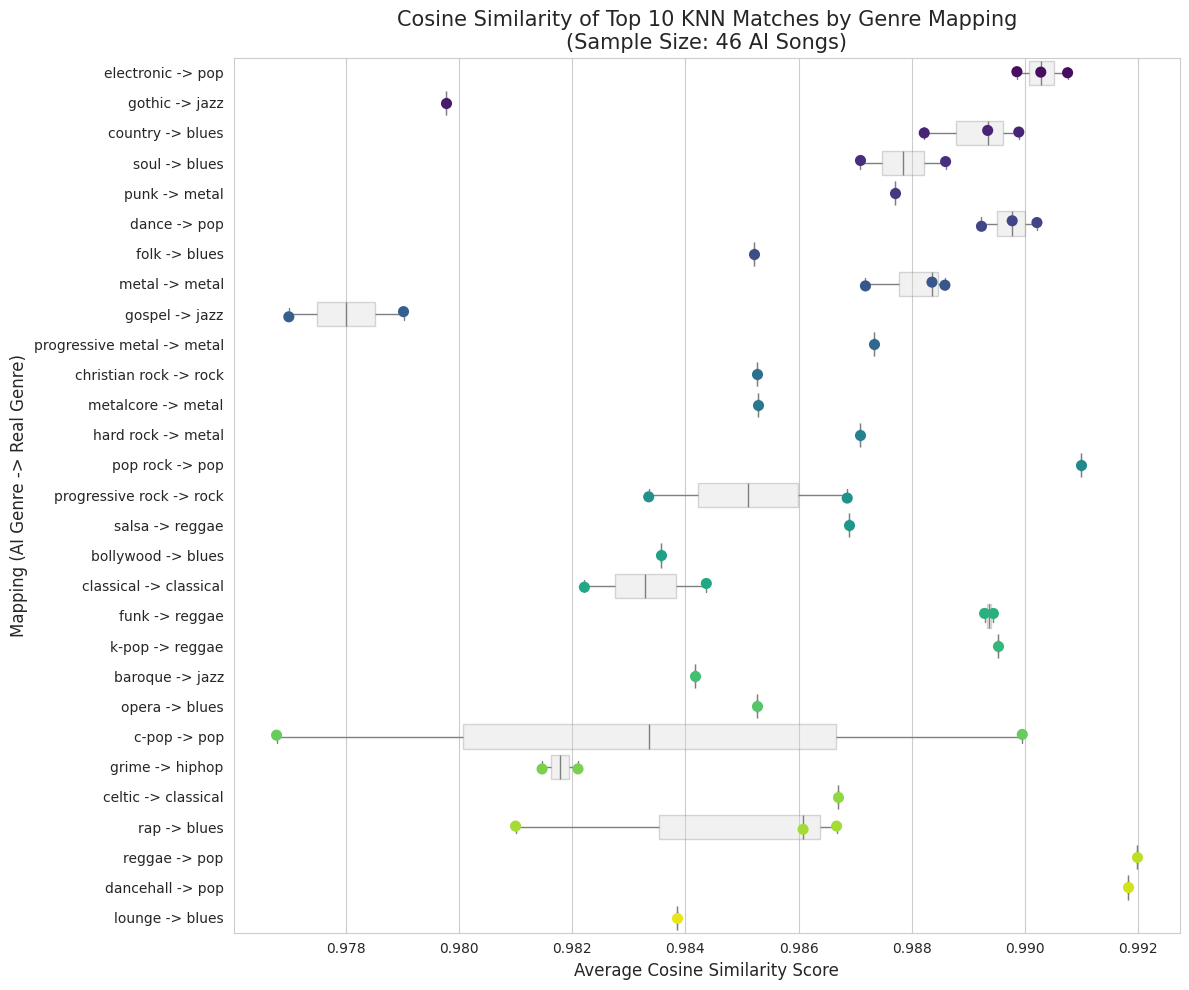

Top 5 Samples with Highest Average Similarity:


,File,AI Genre,Mapped Real Genre,Mapping Label,Average Cosine Similarity
34,fake_54285_suno_0.mp3,reggae,pop,reggae -> pop,0.991978
35,fake_54233_suno_0.mp3,dancehall,pop,dancehall -> pop,0.991820
16,fake_54294_suno_1.mp3,pop rock,pop,pop rock -> pop,0.990985
15,fake_54287_suno_0.mp3,electronic,pop,electronic -> pop,0.990752
28,fake_54260_suno_0.mp3,electronic,pop,electronic -> pop,0.990279


In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# 1. Take 50 random samples (or fewer if list is smaller)
sample_size = 50
num_samples = min(sample_size, len(ai_files_with_genres))
random_samples = random.sample(ai_files_with_genres, num_samples)

results_data = []

print(f"Processing {num_samples} random samples...")

for i, (file_path, ai_genre) in enumerate(random_samples):
    # Map AI genre to Real genre
    mapped_real_genre = map_ai_genre_to_closest_real(
        ai_genre_to_map=ai_genre,
        target_real_genres=target_real_genres,
        gtzan_genre_centroids=gtzan_genre_centroids,
        ai_files_with_genres=ai_files_with_genres
    )

    # Perform KNN Query
    knn_results = knn_query_path(file_path, k=100)

    filtered_results = knn_results[knn_results['label'] == mapped_real_genre]

    top_10 = filtered_results.sort_values(by='score', ascending=False).head(10)

    if not top_10.empty:
        avg_similarity = top_10['score'].mean()

        results_data.append({
            'File': os.path.basename(file_path),
            'AI Genre': ai_genre,
            'Mapped Real Genre': mapped_real_genre,
            'Mapping Label': f"{ai_genre} -> {mapped_real_genre}",
            'Average Cosine Similarity': avg_similarity
        })

# Create DataFrame for analysis
df_results = pd.DataFrame(results_data)

if not df_results.empty:
    plt.figure(figsize=(12, 10))
    sns.set_style("whitegrid")

    sns.stripplot(
        data=df_results,
        x='Average Cosine Similarity',
        y='Mapping Label',
        hue='Mapping Label',
        palette='viridis',
        size=8,
        jitter=True,
        legend=False
    )

    sns.boxplot(
        data=df_results,
        x='Average Cosine Similarity',
        y='Mapping Label',
        color='lightgray',
        fliersize=0, # Hide outliers as they are shown in stripplot
        boxprops=dict(alpha=0.3) # Make boxes transparent
    )

    plt.title(f'Cosine Similarity of Top 10 KNN Matches by Genre Mapping\n(Sample Size: {len(df_results)} AI Songs)', fontsize=15)
    plt.xlabel('Average Cosine Similarity Score', fontsize=12)
    plt.ylabel('Mapping (AI Genre -> Real Genre)', fontsize=12)

    plt.tight_layout()
    plt.show()

    print("Top 5 Samples with Highest Average Similarity:")
    display(df_results.sort_values(by='Average Cosine Similarity', ascending=False).head(5))

else:
    print("No matches found for the selected random samples.")

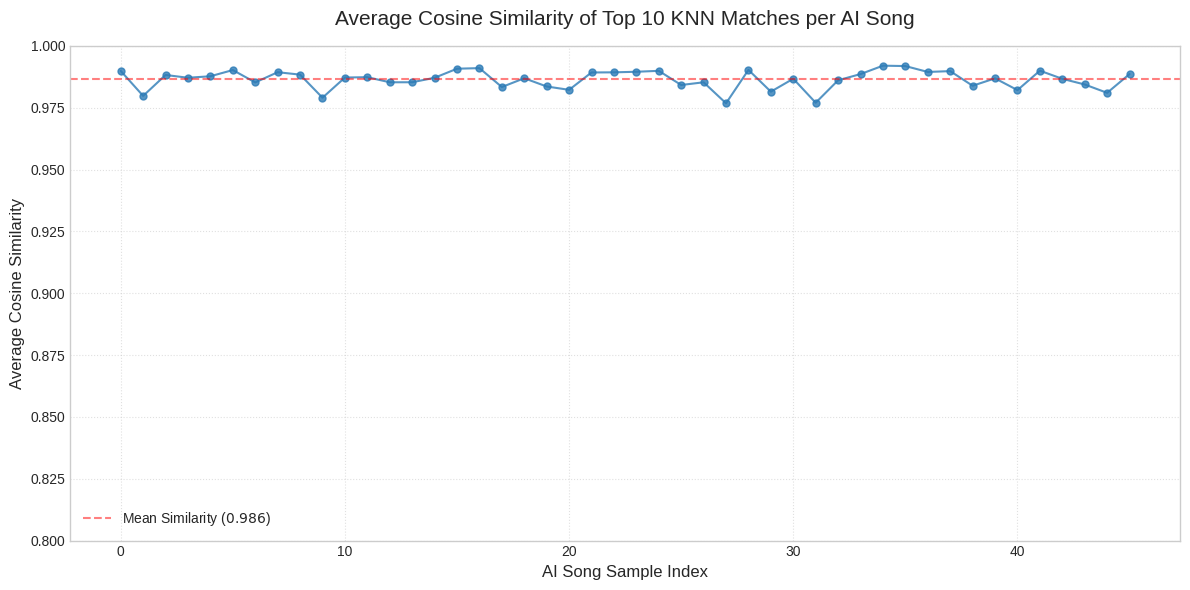

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(
    df_results.index,
    df_results['Average Cosine Similarity'],
    marker='o',          # Circular markers for each data point
    linestyle='-',       # Solid line connecting points
    linewidth=1.5,
    color='#2c7bb6',     # Professional blue color
    markersize=5,
    alpha=0.8
)

overall_mean = df_results['Average Cosine Similarity'].mean()
plt.axhline(y=overall_mean, color='r', linestyle='--', alpha=0.5, label=f'Mean Similarity (${overall_mean:.3f}$)')

plt.ylim(0.8, 1.0)
plt.title('Average Cosine Similarity of Top 10 KNN Matches per AI Song', fontsize=15, pad=15)
plt.xlabel('AI Song Sample Index', fontsize=12)
plt.ylabel('Average Cosine Similarity', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('ai_song_similarity_trend_v2.png')
plt.show()

## Visualizations

In [ ]:
import matplotlib.pyplot as plt

def topk_sims(index, Q, k=10):
    # Q: (nq, d)
    Q = np.ascontiguousarray(Q.astype(np.float32))
    sims, idxs = index.search(Q, k)
    return sims  # (nq, k)

def plot_similarity_distributions(index, X_real_song, ai_files, embed_path, num_ai=200, k=10, seed=0):
    rng = np.random.default_rng(seed)

    # Real->Real: use each real song as a query; take k=2 and use neighbor #2 to avoid self
    sims_rr, idxs_rr = index.search(X_real_song.astype(np.float32), 2)
    real_to_real = sims_rr[:, 1]  # exclude self match at position 0

    # AI->Real: embed a sample of AI files and query top-1 similarity
    if len(ai_files) == 0:
        raise ValueError("ai_files empty")

    m = min(num_ai, len(ai_files))
    sample_paths = rng.choice(ai_files, size=m, replace=False)

    X_ai = np.stack([embed_path(p) for p in sample_paths], axis=0).astype(np.float32)
    sims_ar = topk_sims(index, X_ai, k=1)[:, 0]  # top-1 similarity

    plt.figure(figsize=(10, 6))
    plt.hist(real_to_real, bins=40, alpha=0.6, label="Real→Real (1-NN, leave-one-out)")
    plt.hist(sims_ar, bins=40, alpha=0.6, label="AI→Real (top-1)")
    plt.xlabel("Cosine similarity (inner product on L2-normalized vectors)")
    plt.ylabel("Count")
    plt.title("Similarity distributions: does AI land near real songs?")
    plt.legend()
    plt.show()

    print("Real→Real (1-NN) mean:", float(real_to_real.mean()), "median:", float(np.median(real_to_real)))
    print("AI→Real (top-1) mean:", float(sims_ar.mean()), "median:", float(np.median(sims_ar)))

# Usage:
plot_similarity_distributions(index, X_real_song, ai_files, embed_path, num_ai=200, k=10)


KeyboardInterrupt: 

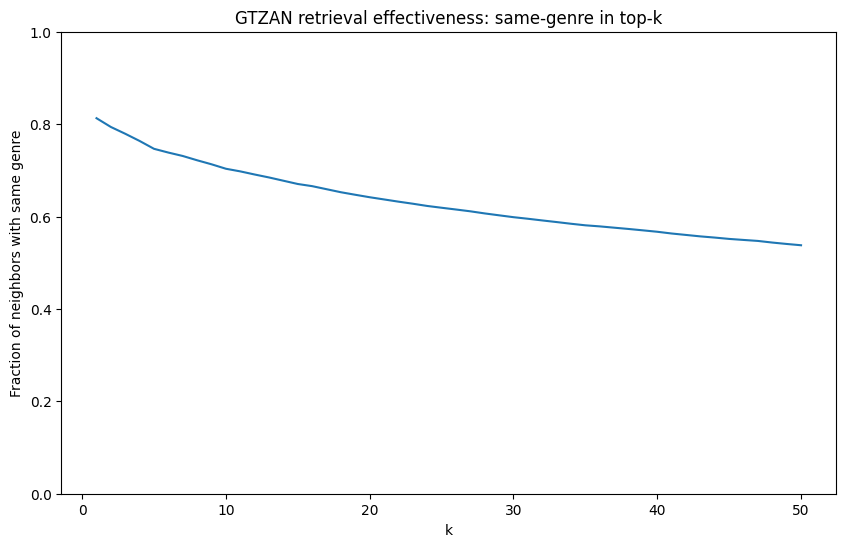

Same-genre@1: 0.8128128128128128
Same-genre@10: 0.7034034034034033
Same-genre@50: 0.5378178178178178


In [ ]:

def same_genre_at_k(index, X_real_song, meta_real, max_k=50):
    labels = meta_real["label"].to_numpy()
    # search max_k+1 so we can drop self
    sims, idxs = index.search(X_real_song.astype(np.float32), max_k + 1)
    idxs = idxs[:, 1:]  # drop self column

    # For each k, compute fraction of neighbors with same label (averaged over queries)
    acc = []
    for k in range(1, max_k + 1):
        neigh_labels = labels[idxs[:, :k]]              # (N, k)
        same = (neigh_labels == labels[:, None])        # (N, k)
        acc.append(same.mean())                         # scalar
    return np.array(acc)

acc = same_genre_at_k(index, X_real_song, meta_real, max_k=50)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 51), acc)
plt.xlabel("k")
plt.ylabel("Fraction of neighbors with same genre")
plt.title("GTZAN retrieval effectiveness: same-genre in top-k")
plt.ylim(0, 1)
plt.show()

print("Same-genre@1:", float(acc[0]))
print("Same-genre@10:", float(acc[9]))
print("Same-genre@50:", float(acc[49]))


In [ ]:
import umap
import matplotlib.pyplot as plt

# GTZAN vectors: X_real_song (N, 512), meta_real['label']
reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
Z_real = reducer.fit_transform(X_real_song)

plt.figure(figsize=(10, 7))
labels = meta_real["label"].astype("category")
plt.scatter(Z_real[:,0], Z_real[:,1], c=labels.cat.codes, s=10)
plt.title("GTZAN OpenL3 embeddings")
plt.show()

NameError: name 'X_real_song' is not defined

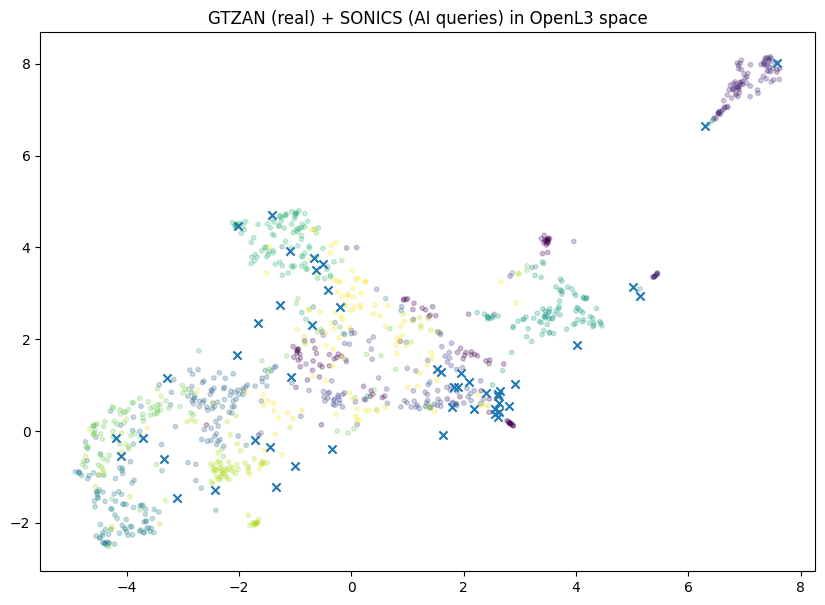

In [ ]:
# embed a few AI queries and project with the same reducer
m = min(50, len(ai_files))
X_ai = np.stack([embed_path(p) for p in ai_files[:m]], axis=0)
Z_ai = reducer.transform(X_ai)

plt.figure(figsize=(10, 7))
plt.scatter(Z_real[:,0], Z_real[:,1], c=labels.cat.codes, s=10, alpha=0.25)
plt.scatter(Z_ai[:,0], Z_ai[:,1], s=35, marker="x")
plt.title("GTZAN (real) + SONICS (AI queries) in OpenL3 space")
plt.show()


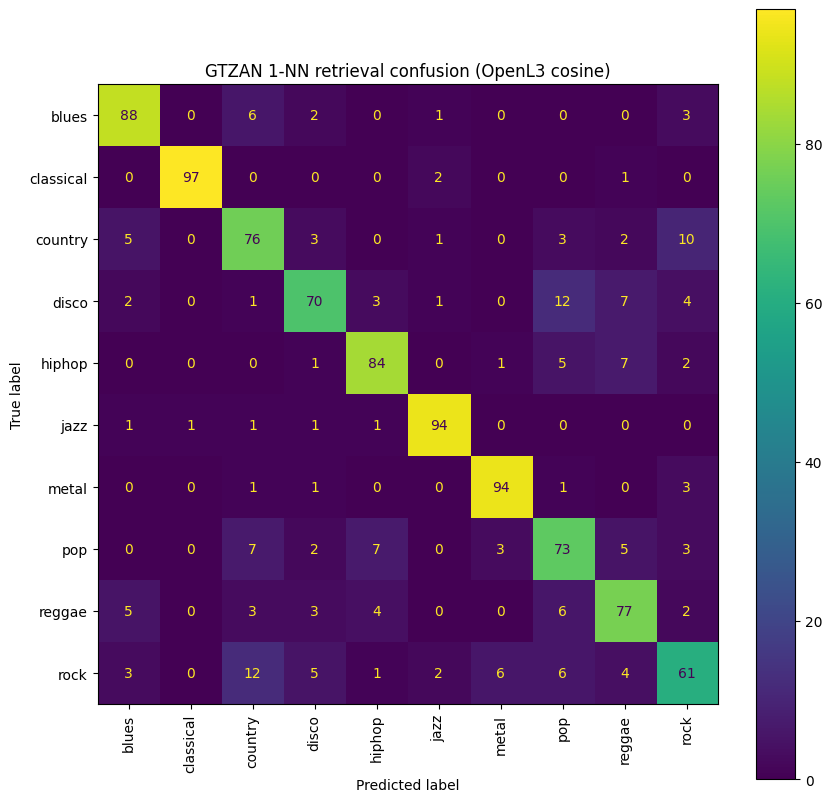

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1-NN excluding self: search k=2 and skip the first (self)
scores, idxs = index.search(X_real_song, 2)
nn = idxs[:, 1]

y_true = meta_real["label"].values
y_pred = meta_real["label"].iloc[nn].values

labels_sorted = sorted(meta_real["label"].unique())
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

disp = ConfusionMatrixDisplay(cm, display_labels=labels_sorted)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, values_format="d")
plt.title("GTZAN 1-NN retrieval confusion (OpenL3 cosine)")
plt.show()


## Top-K Recs for songs predicted as AI using classifier

In [ ]:
# Classified AI songs path
CLASSIFIED_SONICS = os.path.join(project_path, "test AI generated audio files (SONICs)", "SONICS")

In [ ]:
print("AI_DIR =", CLASSIFIED_SONICS)
assert os.path.isdir(CLASSIFIED_SONICS), f"Folder not found: {CLASSIFIED_SONICS}"

# Gather audio paths (recursive)
exts = ("wav", "mp3", "flac", "ogg", "m4a", "aiff", "aif")
ai_paths = []
for e in exts:
    ai_paths += glob.glob(os.path.join(CLASSIFIED_SONICS, "**", f"*.{e}"), recursive=True)

ai_paths = sorted(set(ai_paths))
print("Found", len(ai_paths), "audio files")
for p in ai_paths[:10]:
    print(" -", p)

AI_DIR = /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS
Found 7 audio files
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05480_udio_1.mp3
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05481_udio_0.mp3
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05482_suno_0.mp3
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05482_suno_1.mp3
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05484_udio_0.mp3
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05484_udio_1.mp3
 - /content/drive/MyDrive/ESE 5460/Project/test AI generated audio files (SONICs)/SONICS/fake_05485_suno_0.mp3


In [ ]:

def infer_ai_genre_from_knn(file_path, k=50):
    """
    Infers genre by weighted average similarity over KNN results.
    """
    knn = knn_query_path(file_path, k=k)  # returns df with columns: label, score
    genre_scores = (
        knn.groupby("label")["score"]
        .mean()
        .sort_values(ascending=False)
    )
    return genre_scores.index[0]

# Build (file_path, inferred_ai_genre)
ai_files_with_genres = []
for p in ai_paths:
    inferred_genre = infer_ai_genre_from_knn(p, k=50)
    ai_files_with_genres.append((p, inferred_genre))
    print(f"{os.path.basename(p)}  →  inferred AI genre: {inferred_genre}")

print("Total AI files:", len(ai_files_with_genres))


fake_05480_udio_1.mp3  →  inferred AI genre: hiphop


fake_05481_udio_0.mp3  →  inferred AI genre: rock


fake_05482_suno_0.mp3  →  inferred AI genre: hiphop


fake_05482_suno_1.mp3  →  inferred AI genre: hiphop


fake_05484_udio_0.mp3  →  inferred AI genre: jazz


fake_05484_udio_1.mp3  →  inferred AI genre: pop
fake_05485_suno_0.mp3  →  inferred AI genre: pop
Total AI files: 7


In [ ]:
results_data = []

print(f"Processing {len(ai_files_with_genres)} AI songs...")

for i, (file_path, ai_genre) in enumerate(ai_files_with_genres):
    print(f"[{i+1}/{len(ai_files_with_genres)}] {os.path.basename(file_path)}")

    # Map inferred AI genre → closest real GTZAN genre
    mapped_real_genre = map_ai_genre_to_closest_real(
        ai_genre_to_map=ai_genre,
        target_real_genres=target_real_genres,
        gtzan_genre_centroids=gtzan_genre_centroids,
        ai_files_with_genres=ai_files_with_genres
    )

    # Query many neighbors, then filter
    knn_results = knn_query_path(file_path, k=200)

    filtered_results = knn_results[
        knn_results["label"] == mapped_real_genre
    ]

    top_10 = (
        filtered_results
        .sort_values(by="score", ascending=False)
        .head(10)
    )

    if not top_10.empty:
        results_data.append({
            "File": os.path.basename(file_path),
            "AI Genre": ai_genre,
            "Mapped Real Genre": mapped_real_genre,
            "Mapping Label": f"{ai_genre} → {mapped_real_genre}",
            "Average Cosine Similarity": float(top_10["score"].mean())
        })


Processing 7 AI songs...
[1/7] fake_05480_udio_1.mp3
AI genre 'hiphop' is already a target real genre. No mapping needed.


[2/7] fake_05481_udio_0.mp3
AI genre 'rock' is already a target real genre. No mapping needed.


[3/7] fake_05482_suno_0.mp3
AI genre 'hiphop' is already a target real genre. No mapping needed.


[4/7] fake_05482_suno_1.mp3
AI genre 'hiphop' is already a target real genre. No mapping needed.


[5/7] fake_05484_udio_0.mp3
AI genre 'jazz' is already a target real genre. No mapping needed.


[6/7] fake_05484_udio_1.mp3
AI genre 'pop' is already a target real genre. No mapping needed.


[7/7] fake_05485_suno_0.mp3
AI genre 'pop' is already a target real genre. No mapping needed.


In [ ]:
df_results = pd.DataFrame(results_data)
df_results

,File,AI Genre,Mapped Real Genre,Mapping Label,Average Cosine Similarity
0,fake_05480_udio_1.mp3,hiphop,hiphop,hiphop → hiphop,0.987393
1,fake_05481_udio_0.mp3,rock,rock,rock → rock,0.986904
2,fake_05482_suno_0.mp3,hiphop,hiphop,hiphop → hiphop,0.981298
3,fake_05482_suno_1.mp3,hiphop,hiphop,hiphop → hiphop,0.981139
4,fake_05484_udio_0.mp3,jazz,jazz,jazz → jazz,0.982801
5,fake_05484_udio_1.mp3,pop,pop,pop → pop,0.988742
6,fake_05485_suno_0.mp3,pop,pop,pop → pop,0.990748
